<a href="https://colab.research.google.com/github/HesterWen/-Titanic_Survival/blob/main/titanic_survival.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import io
import requests
import warnings

from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.metrics import accuracy_score, classification_report

warnings.filterwarnings('ignore')

## 載入資料

In [ ]:
url = 'https://raw.githubusercontent.com/HesterWen/Titanic_Survival/refs/heads/main/Titanic-Dataset.csv?token=GHSAT0AAAAAACZY7MLNDOQ3ND4FCL6AOYCSZZ26JSQ'
c = requests.get(url).content
df = pd.read_csv(io.StringIO(c.decode('utf-8')))  # 將解碼後的字串當作檔案

df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [ ]:
df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


## 處理缺失值

In [ ]:
df.isnull().sum()

,0
Survived,0
Pclass,0
Sex,0
Age,177
SibSp,0
Parch,0
Fare,0
Embarked,2


In [ ]:
# 使用中位數填補缺失值
df['Age'].fillna(df['Age'].mean(), inplace=True)

## 視覺化分析

* 票價在200以下且年齡介於20至40的人佔較多數

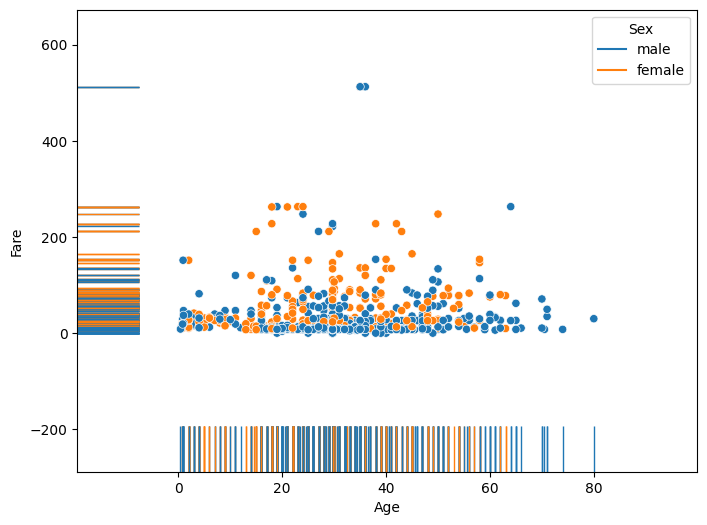

In [ ]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Age', y='Fare', hue='Sex', data=df)
sns.rugplot(x='Age', y='Fare', hue='Sex', data=df, height=0.1)
plt.show()

* 存亡人數的數據圖

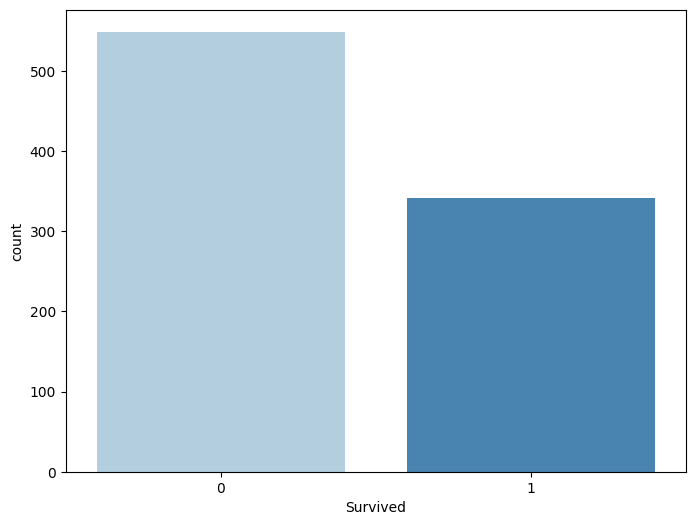

In [ ]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Survived', data=df, palette='Blues')
plt.show()

* 各個艙等的女生存活率都比男生高
* 第三等艙的女生存活率較第一等艙的男生高


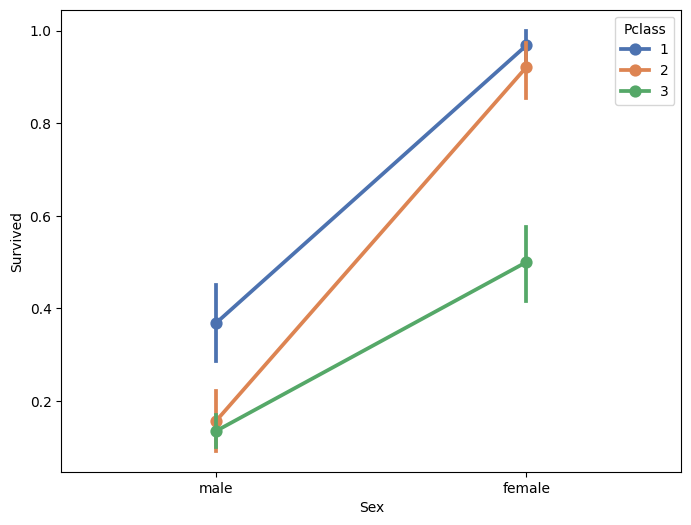

In [ ]:
plt.figure(figsize=(8, 6))
sns.pointplot(x='Sex', y='Survived', hue='Pclass', data=df, palette='deep')
plt.show()

* 第三等艙死亡人數較多；第一、二等艙的存活人數比死亡人數多
* 存活人數排序：Pclass1 > Pclass3 > Pclass2

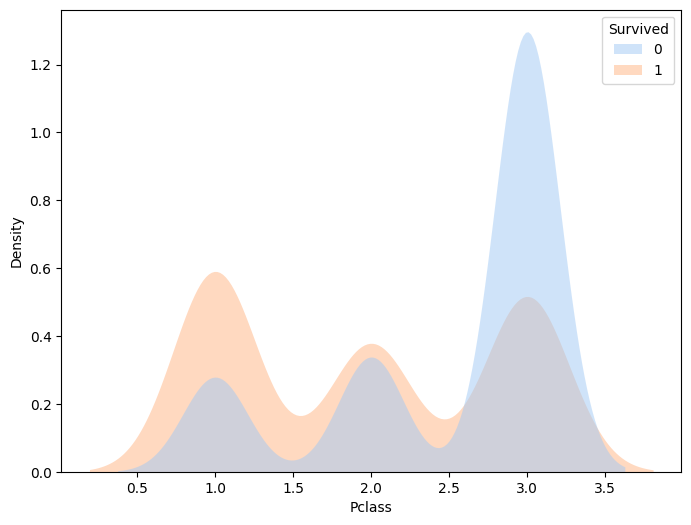

In [ ]:
plt.figure(figsize=(8, 6))
sns.kdeplot(x='Pclass', hue='Survived', fill=True, data=df, palette='pastel', alpha=0.5, linewidth=0, common_norm=False)
plt.show()

* 0至20歲的男生存活比例較高；女生則較低

<Figure size 800x600 with 0 Axes>

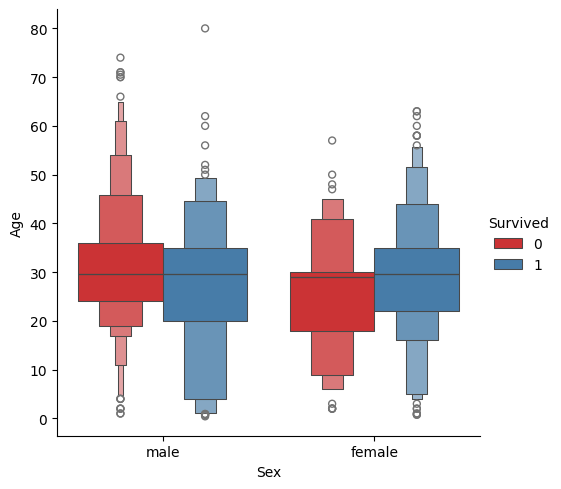

In [ ]:
plt.figure(figsize=(8, 6))
sns.catplot(x='Sex', y='Age', hue='Survived', data=df, kind='boxen', palette='Set1')
plt.show()

* Embarked、Age與Survived的關係圖

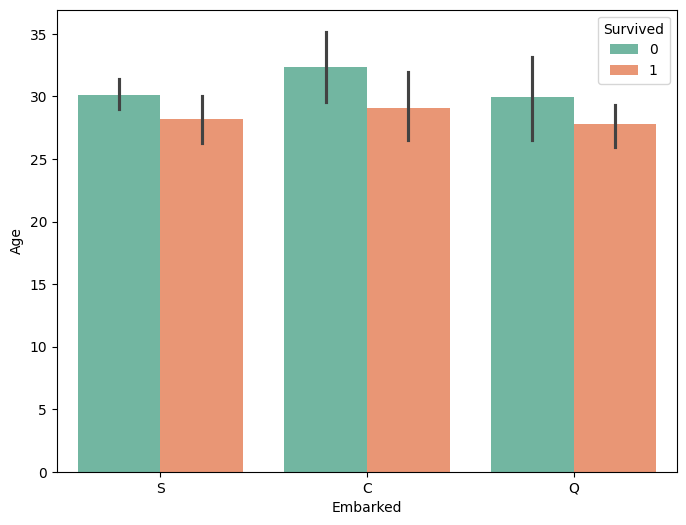

In [ ]:
plt.figure(figsize=(8, 6))
sns.barplot(x='Embarked', y='Age', hue='Survived', data=df, palette='Set2')
plt.show()

### 將 Sex、Embarked 特徵編碼

In [ ]:
labels = {'male': 0, 'female': 1}
df['Sex'] = df['Sex'].map(labels)

In [ ]:
df = pd.get_dummies(df, columns=['Embarked'], drop_first=True)

* 各個特徵間的影響，於Survived的影響最大者為**Sex**

<Axes: >

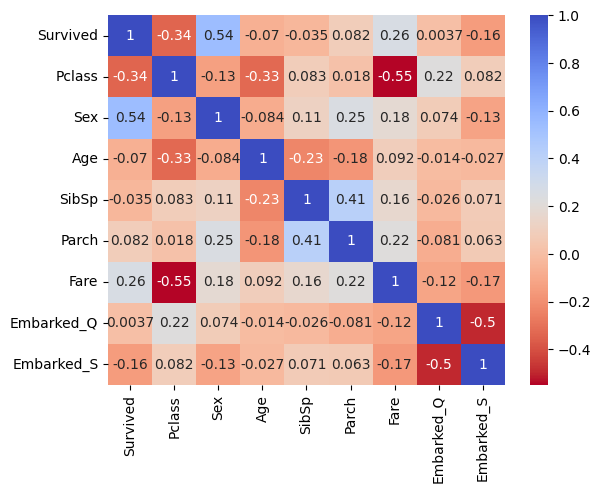

In [ ]:
sns.heatmap(df.corr(), annot=True, cmap='coolwarm_r')

In [ ]:
df.describe(include='all')

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_Q,Embarked_S
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891,891
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,True
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,814,644
mean,0.383838,2.308642,0.352413,29.699118,0.523008,0.381594,32.204208,NaN,NaN
std,0.486592,0.836071,0.477990,13.002015,1.102743,0.806057,49.693429,NaN,NaN
min,0.000000,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000,NaN,NaN
25%,0.000000,2.000000,0.000000,22.000000,0.000000,0.000000,7.910400,NaN,NaN
50%,0.000000,3.000000,0.000000,29.699118,0.000000,0.000000,14.454200,NaN,NaN
75%,1.000000,3.000000,1.000000,35.000000,1.000000,0.000000,31.000000,NaN,NaN


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    891 non-null    int64  
 1   Pclass      891 non-null    int64  
 2   Sex         891 non-null    int64  
 3   Age         891 non-null    float64
 4   SibSp       891 non-null    int64  
 5   Parch       891 non-null    int64  
 6   Fare        891 non-null    float64
 7   Embarked_Q  891 non-null    bool   
 8   Embarked_S  891 non-null    bool   
dtypes: bool(2), float64(2), int64(5)
memory usage: 50.6 KB


## 切割訓練集與測試集

In [ ]:
from sklearn.model_selection import train_test_split
X = df.drop(labels=['Survived'], axis=1)
y = df['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=60)

## 正規化

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
print('Training data shape: ', X_train.shape)
print('Testing data shape: ', X_test.shape)

Training data shape:  (712, 8)
Testing data shape:  (179, 8)


## 建立 XGBoost 模型

In [ ]:
# 建立模型
xgboostModel = XGBClassifier(n_estimators=100, learning_rate=0.3, max_depth=5, gamma=0.1)
# 利用訓練集資料訓練模型
xgboostModel.fit(X_train, y_train)
# 預測測試集
xgb_pred = xgboostModel.predict(X_test)

# 計算準確率
xgb_accuracy = accuracy_score(y_test, xgb_pred)
print(f"XGBoost Accuracy: {xgb_accuracy: .2f}")
print(classification_report(y_test, xgb_pred))

XGBoost Accuracy:  0.83
              precision    recall  f1-score   support

           0       0.82      0.89      0.86       104
           1       0.83      0.73      0.78        75

    accuracy                           0.83       179
   macro avg       0.83      0.81      0.82       179
weighted avg       0.83      0.83      0.82       179



## 建立 Stacking 模型

In [ ]:
# 建立模型
estimators = [
    ('dt', DecisionTreeClassifier()),
    ('knn', KNeighborsClassifier()),
    ('svc', SVC()),
    ('rf', RandomForestClassifier())
]

stackingModel = StackingClassifier(estimators = estimators, final_estimator = LogisticRegression())

# 利用訓練集資料訓練模型
stackingModel.fit(X_train, y_train)
# 預測測試集
stacking_pred = stackingModel.predict(X_test)

# 計算準確率
stacking_accuracy = accuracy_score(y_test, stacking_pred)
print(f"Stacking Accuracy: {stacking_accuracy: .2f}")
print(classification_report(y_test, stacking_pred))

Stacking Accuracy:  0.80
              precision    recall  f1-score   support

           0       0.81      0.88      0.84       104
           1       0.80      0.71      0.75        75

    accuracy                           0.80       179
   macro avg       0.80      0.79      0.80       179
weighted avg       0.80      0.80      0.80       179



## 結論: XGBoost的模型準確率較高

## 儲存模型

In [ ]:
import pickle
import gzip

with gzip.GzipFile('./model/titanic_survival.pgz', 'w') as f:
  pickle.dump(xgboostModel, f)